In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def custom_make_blobs(n_samples=100, n_features=2, centers=3, random_state=None):
    """
    生成聚类数据
    
    参数:
    n_samples: 样本数量
    n_features: 特征数量
    centers: 聚类中心数量
    random_state: 随机种子
    
    返回:
    X: 特征矩阵
    y: 标签向量
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # 生成随机聚类中心
    centers_coords = np.random.randn(centers, n_features) * 10
    
    # 初始化数据
    X = np.zeros((n_samples, n_features))
    y = np.zeros(n_samples, dtype=int)
    
    # 为每个样本分配聚类中心
    samples_per_center = n_samples // centers
    remainder = n_samples % centers
    
    start_idx = 0
    for i in range(centers):
        n_samples_i = samples_per_center + (1 if i < remainder else 0)
        end_idx = start_idx + n_samples_i
        
        # 生成围绕中心的数据点
        X[start_idx:end_idx] = centers_coords[i] + np.random.randn(n_samples_i, n_features)
        y[start_idx:end_idx] = i
        
        start_idx = end_idx
    
    # 打乱数据
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    return X[indices], y[indices]

In [3]:
class Node:
    def __init__(self, feature_idx=None, threshold=None, children=None, value=None):
        self.feature_idx = feature_idx  # 特征索引
        self.threshold = threshold      # 分割阈值
        self.children = children        # 子节点字典
        self.value = value              # 叶节点的类别


In [4]:
class ID3DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, random_state=None):
        """
        ID3决策树分类器
        
        参数:
        max_depth: 树的最大深度
        min_samples_split: 分裂所需的最小样本数
        random_state: 随机种子
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def fit(self, X, y):
        """训练决策树"""
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        
        # 对连续特征进行离散化处理
        self.thresholds = {}
        for feature_idx in range(self.n_features):
            unique_values = np.unique(X[:, feature_idx])
            if len(unique_values) > 10:  # 如果取值太多，就取中点作为阈值
                thresholds = []
                for i in range(len(unique_values) - 1):
                    thresholds.append((unique_values[i] + unique_values[i+1]) / 2)
                self.thresholds[feature_idx] = thresholds
            else:
                self.thresholds[feature_idx] = unique_values
        
        self.root = self._grow_tree(X, y)
        return self
    
    def _grow_tree(self, X, y, depth=0):
        """递归构建决策树"""
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # 检查停止条件
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           n_classes == 1:
            # 创建叶节点
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        # 计算当前数据集的熵
        current_entropy = self._entropy(y)
        
        # 寻找最佳分割
        best_feature, best_threshold, best_gain = self._best_split(X, y, current_entropy)
        
        # 如果找不到有效分割，创建叶节点
        if best_feature is None or best_gain <= 0:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        # 根据最佳分割创建子节点
        children = {}
        
        # 对于连续特征，二分为 <= threshold 和 > threshold
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        
        # 确保两边都有数据
        if np.sum(left_indices) > 0:
            children["left"] = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        if np.sum(right_indices) > 0:
            children["right"] = self._grow_tree(X[right_indices], y[right_indices], depth + 1)
        
        return Node(feature_idx=best_feature, threshold=best_threshold, children=children)
    
    def _best_split(self, X, y, current_entropy):
        """寻找最佳分割点"""
        m, n = X.shape
        if m <= 1:
            return None, None, 0
        
        best_gain = 0
        best_feature, best_threshold = None, None
        
        # 遍历所有特征
        for feature_idx in range(n):
            # 获取该特征的所有可能阈值
            for threshold in self.thresholds[feature_idx]:
                # 分割数据
                left_indices = X[:, feature_idx] <= threshold
                right_indices = ~left_indices
                
                # 确保两边都有数据
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue
                
                # 计算信息增益
                left_entropy = self._entropy(y[left_indices])
                right_entropy = self._entropy(y[right_indices])
                
                n_left, n_right = np.sum(left_indices), np.sum(right_indices)
                weighted_entropy = (n_left * left_entropy + n_right * right_entropy) / m
                
                # 信息增益 = 当前熵 - 加权子节点熵
                gain = current_entropy - weighted_entropy
                
                # 更新最佳分割
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _entropy(self, y):
        """计算熵"""
        m = len(y)
        if m == 0:
            return 0
        
        # 计算每个类别的概率
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / m
        
        # 计算熵: -sum(p * log2(p))
        entropy = -np.sum([p * math.log2(p) for p in probabilities if p > 0])
        return entropy
    
    def _most_common_label(self, y):
        """返回最常见的类别"""
        unique_values, counts = np.unique(y, return_counts=True)
        return unique_values[np.argmax(counts)]
    
    def predict(self, X):
        """预测样本类别"""
        return np.array([self._predict_sample(sample) for sample in X])
    
    def _predict_sample(self, sample):
        """预测单个样本的类别"""
        node = self.root
        
        while node.value is None:
            if sample[node.feature_idx] <= node.threshold:
                node = node.children["left"]
            else:
                node = node.children["right"]
                
        return node.value


In [5]:
class ID3RandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, random_state=None):
        """
        基于ID3的随机森林分类器
        
        参数:
        n_estimators: 决策树数量
        max_depth: 每棵树的最大深度
        min_samples_split: 分裂所需的最小样本数
        random_state: 随机种子
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.trees = []
    
    def fit(self, X, y):
        """训练随机森林"""
        self.n_classes = len(np.unique(y))
        n_samples, n_features = X.shape
        
        # 设置随机种子
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # 训练多棵决策树
        for i in range(self.n_estimators):
            # 使用不同的随机种子
            tree_seed = None if self.random_state is None else self.random_state + i
            
            # 创建决策树
            tree = ID3DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=tree_seed
            )
            
            # 自助采样(Bootstrap)
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap, y_bootstrap = X[indices], y[indices]
            
            # 训练决策树
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)
        
        return self
    
    def predict(self, X):
        """预测样本类别"""
        # 获取每棵树的预测结果
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        
        # 对每个样本进行投票
        predictions = np.zeros(X.shape[0], dtype=int)
        for i in range(X.shape[0]):
            # 找出每个样本的最常见预测类别
            unique_values, counts = np.unique(tree_predictions[:, i], return_counts=True)
            predictions[i] = unique_values[np.argmax(counts)]
        
        return predictions

In [6]:
def custom_cross_val_score(estimator, X, y, cv=5):
    """
    交叉验证评分
    
    参数:
    estimator: 分类器
    X: 特征矩阵
    y: 标签向量
    cv: 折数
    
    返回:
    scores: 每折的准确率
    """
    n_samples = len(y)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    # 划分折
    fold_size = n_samples // cv
    scores = []
    
    for i in range(cv):
        # 确定测试集索引
        start = i * fold_size
        end = (i + 1) * fold_size if i < cv - 1 else n_samples
        test_indices = indices[start:end]
        train_indices = np.setdiff1d(indices, test_indices)
        
        # 划分训练集和测试集
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]
        
        # 训练模型 - 只传递__init__方法中定义的参数
        if isinstance(estimator, ID3DecisionTreeClassifier):
            model = ID3DecisionTreeClassifier(
                max_depth=estimator.max_depth,
                min_samples_split=estimator.min_samples_split,
                random_state=estimator.random_state
            )
        elif isinstance(estimator, ID3RandomForestClassifier):
            model = ID3RandomForestClassifier(
                n_estimators=estimator.n_estimators,
                max_depth=estimator.max_depth,
                min_samples_split=estimator.min_samples_split,
                random_state=estimator.random_state
            )
        else:
            # 如果是其他类型的分类器，使用默认参数
            model = estimator.__class__()
        
        model.fit(X_train, y_train)
        
        # 预测并计算准确率
        y_pred = model.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / len(y_test)
        scores.append(accuracy)
    
    return np.array(scores)

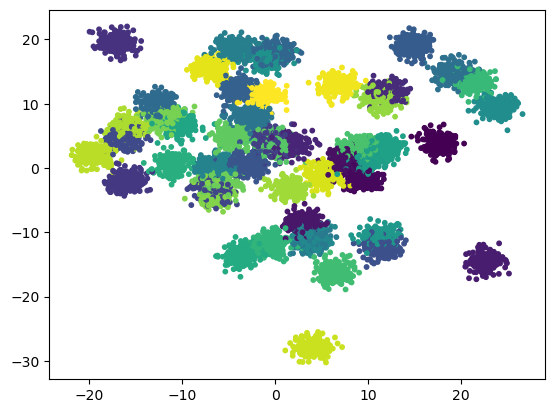

AttributeError: 'ID3DecisionTreeClassifier' object has no attribute 'random_state'

In [7]:
x, y = custom_make_blobs(n_samples=10000, n_features=6, centers=50, random_state=0)

# 可视化数据
plt.scatter(x[:, 0], x[:, 1], c=y, s=10)
plt.show()

# 创建并训练ID3决策树
dt_classifier = ID3DecisionTreeClassifier(max_depth=10, random_state=0)
dt_classifier.fit(x, y)
dt_scores = custom_cross_val_score(dt_classifier, x, y, cv=5)
print("ID3决策树交叉验证准确率:", dt_scores.mean())

# 创建并训练基于ID3的随机森林
rf_classifier = ID3RandomForestClassifier(n_estimators=10, max_depth=10, random_state=0)
rf_classifier.fit(x, y)
rf_scores = custom_cross_val_score(rf_classifier, x, y, cv=5)
print("ID3随机森林交叉验证准确率:", rf_scores.mean())